# M1. Actividad
### Elaborado por: **Alejandro Martínez Luna** - **A01276775**

# Instrucciones 




Para este problema, deberás entregar, de manera individual, un informe en PDF que estudie las estadísticas de un robot de limpieza reactivo, así como el enlace al repositorio en Github del código desarrollado para esta actividad. El código debe ajustarse al estilo solicita en el siguiente documento.



## Dado:
* Habitación de MxN espacios.
* TiempoNúmero de agentes.
* TiempoPorcentaje de celdas inicialmente sucias.
* TiempoTiempo máximo de ejecución.

## Realiza la siguiente simulación

* Inicializa las celdas sucias (ubicaciones aleatorias).
* Todos los agentes empiezan en la celda [1,1].
* En cada paso de tiempo:
  *  Si la celda está sucia, entonces aspira.
  * Si la celda está limpia, el agente elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda).
* Se ejecuta el tiempo máximo establecido.

## Deberás recopilar la siguiente información durante la ejecución:

* Tiempo necesario hasta que todas las celdas estén limpias (o se haya llegado al tiempo máximo).
* Porcentaje de celdas limpias después del termino de la simulación.
* Número de movimientos realizados por todos los agentes.

Analiza cómo la cantidad de agentes impacta el tiempo dedicado, así como la cantidad de movimientos realizados. Desarrollar un informe con lo observado.

# Código

In [77]:
#La clase Model para manejar los agentes y la clase Agent para un definir un agente.
from mesa import Agent, Model

# Debido a que necesitamos varios agentes por celda, elegimos ''MultiGrid''.
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Con ''DataCollector'', vamos a recuperar información del modelo.
from mesa.datacollection import DataCollector

# matplotlib lo vamos a utilizar para realizar una ''animación'' de mi modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

# Definimos otros paquete que vamos a usar para medir el tiempo de ejecución del modelo
import time
import datetime

## Grid

In [78]:
LIMIT = 10000
def get_grid(model):
    """ Esta función nos permite obtener el estado de los diferentes agentes.
        *param* model : Modelo del que obtendrá la información. 
        *return* una matriz con la información del estado de cada uno de los agentes."""
    grid = np.zeros((model.grid.width, model.grid.height))
    for ren in range(model.grid.width):
        for col in range(model.grid.height):
            if model.grid.is_cell_empty((ren, col)):
                grid[ren][col] = model.floor[ren][col] * 2
            else:
                grid[ren][col] = 1
    return grid

## Agente

In [79]:
class RobotVacuumCleanerAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.num_moves = 0
        self.options = np.array([[-1, -1], [-1,  0], [-1, +1],
                                [0, -1],           [0, +1],
                                [+1, -1], [+1,  0], [+1, +1]])

    def can_move(self, col, ren):
        return (col >= 0 and col < self.model.grid.width and
                ren >= 0 and ren < self.model.grid.height)

    def step(self):
        if self.model.floor[self.pos[0]][self.pos[1]] == 1:
            self.model.floor[self.pos[0]][self.pos[1]] = 0
        else:
            i = int(np.random.rand() * LIMIT) % len(self.options)
            col = self.pos[0] + self.options[i][0]
            ren = self.pos[1] + self.options[i][1]

            if self.can_move(col, ren):
                self.model.grid.move_agent(self, (col, ren))
                self.num_moves += 1


## Modelo

In [80]:
class RobotVaccumCleanerModel (Model):
    def __init__(self, height, width, num_agents=1, dirty_cells_percentage=0.5, start_time=0.0):
        self.num_agents = num_agents
        self.num_steps = 0
        self.dirty_cells_percentage = dirty_cells_percentage
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.model_steps = 0
        self.start_time = start_time 

        # Ensuciamos el piso
        self.floor = np.zeros((width, height))
        amount = int((width * height) * dirty_cells_percentage)

        for i in range(amount):
            finished = False

            while not finished:
                ren = int(np.random.rand() * LIMIT) % height
                col = int(np.random.rand() * LIMIT) % width

                if self.floor[ren][col] == 0:
                    self.floor[ren][col] = 1
                    finished = True

      # Gereamos los agentes
        for i in range(self.num_agents):
            robot = RobotVacuumCleanerAgent(i, self)
            self.grid.place_agent(robot, (1, 1))
            self.schedule.add(robot)

        # Se realiza la recoleccion de datos del modelo
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})

    # function that returns the percentaje of clean cells
    def clean_cells_percentage(self):
        return 1 - np.sum(self.floor) / (self.grid.width * self.grid.height)

    # function that returns the average number of steps performed by agents
    def average_steps(self):
        return np.mean([agent.num_moves for agent in self.schedule.agents])

    # function that returns the average number of steps performed by the model
    def model_average_steps(self):
        return self.model_steps

    # Function that returns the execution time of the model from start to finish in seconds
    def time_of_execution(self):
        return (round(time.time() - self.start_time, 4)*10)

    def is_all_clean(self):
        return np.all(self.floor == 0)

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.model_steps += 1


## Ejecución

### Modelo 1 - Limpiando todas las celdas

In [81]:
# Definimos el tamaño del Grid
GRID_SIZE = 20

# Definimos el número máximo de generaciones a correr
MAX_ITERATIONS = 200

# Definimos el numero de agentes que vamos a utilizar
NUM_AGENTS = 30

# El porcentaje de las celdas que estarán sucias
DIRTY_CELLS_PERCENTAGE = 0.7

# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()
model = RobotVaccumCleanerModel(GRID_SIZE, GRID_SIZE, NUM_AGENTS, DIRTY_CELLS_PERCENTAGE, start_time)
i = 1
while not model.is_all_clean():
    model.step()
    i += 1

# Imprimimos el tiempo que le tomó correr al modelo.
print("-------------------------------------------------------------------------------------")
print("Numero de agentes: ", model.num_agents)
print("\nNumero de movimientos promedio de los agentes: \t", model.average_steps())
print("Numero de movimientos promedio del modelo: \t", model.model_average_steps())

print("\nPorcentaje de celdas limpias: \t\t", (model.clean_cells_percentage()*100), "%")
print('Tiempo de ejecución del modelo: \t', model.time_of_execution(), "segundos")
print("-------------------------------------------------------------------------------------")


-------------------------------------------------------------------------------------
Numero de agentes:  30

Numero de movimientos promedio de los agentes: 	 431.1666666666667
Numero de movimientos promedio del modelo: 	 480

Porcentaje de celdas limpias: 		 100.0 %
Tiempo de ejecución del modelo: 	 2.234 segundos
-------------------------------------------------------------------------------------


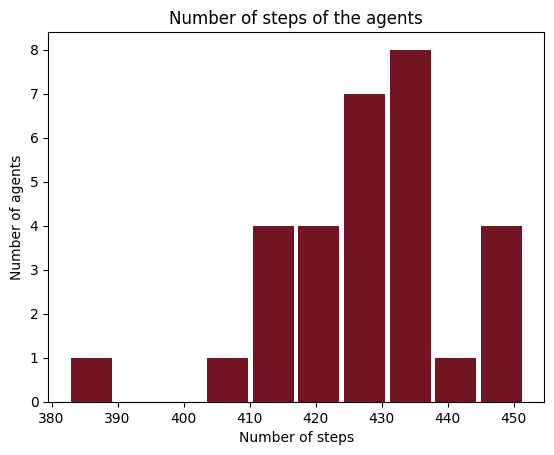

In [82]:
plt.hist([agent.num_moves for agent in model.schedule.agents], color='#721422',align='left', rwidth=.9)
plt.title('Number of steps of the agents')
plt.xlabel('Number of steps')
plt.ylabel('Number of agents')
plt.show()


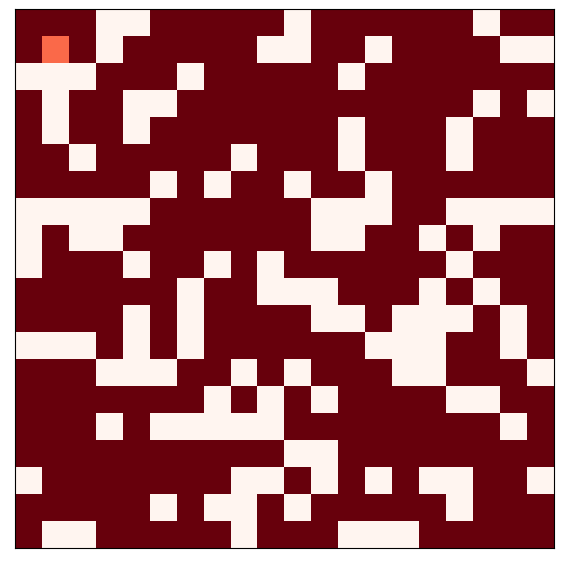

In [83]:
all_grid = model.datacollector.get_model_vars_dataframe()

fig, axs = plt.subplots(figsize=(7, 7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.Reds)


def animate(i):
  patch.set_data(all_grid.iloc[i][0])


anim = animation.FuncAnimation(fig, animate, frames=model.model_average_steps())
anim
